### Normal Squares, toggleable features 
-   This code creates a series of squares around the perimeter of a cell, normal to its outline, that can then be extracted into images
-   second_pass and variable_length can be toggled for additional overlap accuracy and varying lenghts of squares, respectively
    - If using varying length, I reccomend using a slightly higher overlap threshold as it still provides serviceable results but can yield few to no squares otherwise

In [2]:
import numpy as np
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import random


#Read image and threshold for mask:
#This basic method works best with already cropped cells
#I have another at the bottom that is slightly better for cells with backgrounds
image1=cv2.imread("h2114153  h&e_ROI_1 Epithelia.png")
image1_gray = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
_,whole_thresh=cv2.threshold(image1_gray,1,255,cv2.THRESH_BINARY)


In [169]:


# It is designed to take in a cell that has been seperated from the background
# The mask/thresh should have clear lines for a contour to be drawn along

def find_largest_countour(binary_image):
    """Calulate the largest vector in a binary image-typically the outline"""
    contours, _=cv2.findContours(binary_image,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    return max(contours,key=cv2.contourArea)


def calculate_contour_normals(contour,smooting_size=5):
    """
    Calculate normal vectors along the contour
    """
    #The normal vector is parallel to contour at a point and ensures the square goes in to the cell
    #Smoothing size is how many points before and after current to look back and find tangent
    
    #Reshape contour into (x,y) pairings
    points=contour.reshape(-1,2)

    n_points=len(points)
    tangents=np.zeros_like(points,dtype=float)

    for i in range(n_points):
        #get indices, % handles wraparound
        prev_idx=(i-smooting_size)%n_points
        next_idx=(i+smooting_size)%n_points
        tangent=points[next_idx]-points[prev_idx]

        #divide by length of tangent to normalize and add num for stability
        tangent=tangent/(np.linalg.norm(tangent)+1e-8)
        tangents[i]=tangent

    #This just rotates the tangents to find normals
    #Negative from next-prev approach, could switch normals' signs for outward pointing 
    normals=np.zeros_like(tangents)
    normals[:,0]=-tangents[:,1]
    normals[:,1]=tangents[:,0]

    return normals

def calculate_square_corners(point,normal,square_size,binary_image,variable_length=False):
    """Caluclate square corners so that top edge is touching the contour point"""
    #Find tangent for point for top edge (inverse of previous formula)
    tangent=np.array([-normal[1],normal[0]])
    half_size=square_size/2

    if variable_length==True:
        i=1
        val=255
        while np.all(val>0):  # Continue until we encounter a black pixel
            # Calculate the point along the normal direction
            test_point = (point - (normal * i)).astype(int)
            #test_point = np.clip(test_point, 0, np.array(image.shape) - 1)  # Prevent out-of-bounds

            
            # Get the pixel value at the test point
            val = binary_image[test_point[1], test_point[0]]  # Assuming (x, y) -> [row, col] format
            
            i += 10  # Move further along the normal direction

        # At this point, we've found the point where the normal reaches a black pixel
        extended_length = i
        #half_size=i//2
        if extended_length<50:
            extended_length=square_size

    else:
        extended_length=square_size

    #Take point and extend from it in tangent and normal directions
    #Normalization allows for multiplication by square size
    corners=np.array([
        point+(tangent*half_size),
        point-(tangent*half_size),
        point-(tangent*half_size)-(normal*extended_length),
        point+(tangent*half_size)-(normal*extended_length)
    ])
    return corners

def calculate_overlap_area(square1,square2):
    """
    Calculate approx overlap between two squares
    Return ovelap area and center-center dist
    """
    #Average x and y to find center
    center1=np.mean(square1,axis=0)
    center2=np.mean(square2,axis=0)
    distance=np.linalg.norm(center1-center2)

    #Calculate the diagonal distance of the first square (using opposite corners)
    diagonal=np.linalg.norm(square1[0]-square1[2])
    #Rudimentary distance calculation, how much of the distance could be explained by overlapping diagonals
    overlap=max(0,1-(distance/diagonal))

    return overlap,distance

def calculate_polygon_overlap(shape1,shape2):
    '''
    calculate more precise overlap between 2 shapes
    '''
    from shapely.geometry import Polygon

    #define polygons from squares
    poly1=Polygon(shape1)
    poly2=Polygon(shape2)


    if poly1.intersects(poly2):
        intersection_area=poly1.intersection(poly2).area
        #use smallest area for ratio to be conservative
        smallest_area=min(poly1.area,poly2.area)
        overlap=intersection_area/smallest_area
    else:
        overlap=0
    
    return overlap



def create_dense_squares(contour,normals,image,square_size=64,step=5,variable_length=True):
    """Create dense squares along the contour"""
    points=contour.reshape(-1,2)
    n_points=len(points)
    squares=[]
    indices=[]

    #Create squares at intervals
    for i in range(0,n_points,step):
        corners=calculate_square_corners(points[i],normals[i],square_size,image,variable_length=True)
        squares.append(corners)
        indices.append(i)

    return squares,indices

def remove_overlapping_squares(squares,indices,overlap_thresh=0.3,look_back=3,second_pass=True):
    """
    Remove overlapping squares but continue continuity
    Uses a greedy-based approach
    """
    if not squares:
        return [],[]
    
    n_squares=len(squares)
    kept_squares=[]
    kept_indices=[]
    final_squares=[]
    final_indices=[]
    excluded=set()

    #Keep first
    kept_squares.append(squares[0])
    kept_indices.append(indices[0])
    last_kept_idx=0

    #Remaining squares in sequence
    for i in range(1,n_squares):
        if i in excluded:
            continue

        current_square=squares[i]
        overlap_found=False


        #Check for overlap with recent squares
        for j in range(max(0,len(kept_squares)-look_back),len(kept_squares)):
            overlap,_=calculate_overlap_area(current_square,kept_squares[j])

            if overlap>overlap_thresh:
                overlap_found=True
                break
        #Keep squares that meet thresh
        if not overlap_found:
            kept_squares.append(current_square)
            kept_indices.append(indices[i])
            last_kept_idx=i

            #Mark squares to exclude if they're too close to the current one
            #for k in range(i+1, min(i+3,n_squares)):
            #    overlap, _=calculate_overlap_area(current_square,squares[k])
            #    if overlap>overlap_thresh:
            #        excluded.add(k)

    if second_pass==True:

        #Run again against all remaining squares
        for i,square in enumerate(kept_squares):
            overlap_found=False
            for j in range(len(kept_squares)):
                if i!=j:
                    overlap=calculate_polygon_overlap(square,kept_squares[j])
                
                if overlap>overlap_thresh:
                    overlap_found=True
                    break
            if not overlap_found:
                final_squares.append(square)
                final_indices.append(kept_indices[i])
        return final_squares, final_indices
    else:
        return kept_squares,kept_indices
                
    

def draw_image_squares(image,squares,color=(255,0,0),thickness=20):
    """"Draw kept squares on image"""
    grid_img=image.copy()

    for square in squares:
        points=square.astype(np.int32)
        cv2.polylines(
            grid_img,
            [points],
            isClosed=True,
            color=color,
            thickness=thickness
        )
    return grid_img

def normal_squares_from_contour(image,binary_image,square_size=64,step=5,overlap_thresh=0.3,smoothing_size=5,look_back=3, second_pass=True, variable_length=False):
    """
    Main function to find normals and tangents of contour and create corresponding squares

    Args:
        image: Original Image
        binary_mask: Binary mask of main shape
        square_size:Desired size of squares
        step: points to skip between initial dense squares drawing
        overlap_threshold:Max allowed overlap between squares (0-1)
        smoothing_size:# of Points considered before and after when creating normals
        look_back:#  of squares to look back for overlap when removing dense
        second_pass: if remainign squares after initial remove should be checked by polygon overlap
        variable_length: if squares shoudl extend length until meeting black_pixel in mask
        
    """

    contour=find_largest_countour(binary_image)
    normals=calculate_contour_normals(contour,smooting_size=smoothing_size)

    #Create initial squares
    squares,indices=create_dense_squares(contour,normals,image,square_size=square_size,step=step,variable_length=variable_length)

    #Remove overlapping
    final_squares,final_indices=remove_overlapping_squares(squares,indices,overlap_thresh=overlap_thresh,look_back=look_back,second_pass=second_pass)

    grid_img=draw_image_squares(image,final_squares)

    #Plot image and contour
    plt.imshow(grid_img)
    plt.plot(contour[:,0,0],contour[:,0,1],'r',alpha=0.5,label='Contour')

    return grid_img,contour,squares

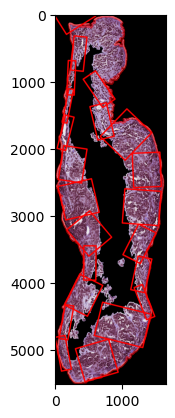

In [180]:
result_image, contour, squares = normal_squares_from_contour(
     image1,
     whole_thresh,
     square_size=512,
     step=25,
     overlap_thresh=0.3,
     smoothing_size=30,
     look_back=4,
     second_pass=True,
     variable_length=False
 )